In [1]:
import numpy as np 
import pandas as pd 
import csv
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
#import mylibs11 as l11


from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import ModelCheckpoint  




%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(42)

# LOAD PREPARED DATASET

In [3]:
btc_data = pd.read_csv('BTC_DATA_fin.csv', index_col=0)
btc_data.index = pd.to_datetime(btc_data.index)

# TRAIN TEST SPLIT

In [4]:
#shift data
features = btc_data.shift(1).dropna() #.drop('BTC_Close', 1)
target = btc_data['BTC_Close'][1:]
prediction_days = 90

In [5]:
features_train = features[:len(features)-prediction_days]
features_test = features[len(features)-prediction_days:]

target_train = target[:len(features)-prediction_days]
target_test = target[len(features)-prediction_days:]

# NORMALIZATION

In [6]:
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
features_train_scaled = pd.DataFrame(X_min_max_scaler.fit_transform(features_train), 
                                     columns=features_train.columns, index=features_train.index)
features_test_scaled = pd.DataFrame(X_min_max_scaler.transform(features_test),
                                    columns=features_test.columns,index=features_test.index)
target_train_scaled = y_min_max_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = y_min_max_scaler.transform(target_test.values.reshape(-1, 1))

# Univariate LSTM Models

## Vanilla LSTM

In [7]:
X = features_train_scaled.values

In [8]:
X_test = features_test_scaled.values

In [9]:
#rescale to 1d
y = target_train_scaled.ravel()
y_test = target_test_scaled.ravel()

In [11]:
n_features = 1 #unvariate so we predict 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [12]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [13]:
X.shape

(1946, 29, 1)

In [17]:
# define model 
model = Sequential() 
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], n_features))) 
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit 
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_vanilla.hdf5', 
                               verbose=1, monitor='val_loss', save_best_only=True)
history = model.fit(X, y, epochs=50, validation_split=0.1, verbose=1)

Train on 1751 samples, validate on 195 samples
Epoch 1/50
1751/1751 [==============================] - 4s 2ms/step - loss: 0.0224 - val_loss: 0.0808
Epoch 2/50
1751/1751 [==============================] - 3s 2ms/step - loss: 0.0075 - val_loss: 0.0094
Epoch 3/50
1751/1751 [==============================] - 3s 2ms/step - loss: 0.0169 - val_loss: 0.0599
Epoch 4/50
1751/1751 [==============================] - 3s 2ms/step - loss: 0.0119 - val_loss: 0.0208
Epoch 5/50
1751/1751 [==============================] - 3s 2ms/step - loss: 0.0094 - val_loss: 0.0334
Epoch 6/50
1751/1751 [==============================] - 3s 2ms/step - loss: 0.0062 - val_loss: 0.0293
Epoch 7/50
1751/1751 [==============================] - 3s 2ms/step - loss: 0.0041 - val_loss: 0.0119
Epoch 8/50
1751/1751 [==============================] - 3s 1ms/step - loss: 0.0032 - val_loss: 0.0096
Epoch 9/50
1751/1751 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 10/50
1751/1751 [============

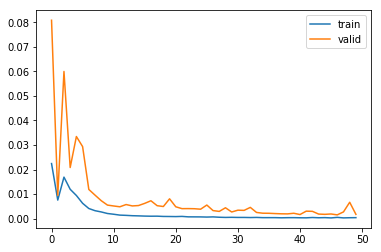

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [21]:
preds = model.predict(X_test)

In [22]:
preds= y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test=y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))

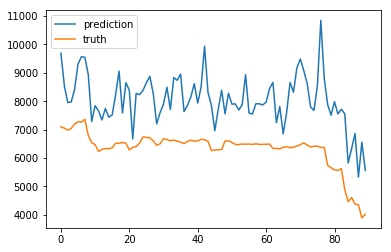

In [23]:
plt.plot(preds.ravel(), label='prediction')
plt.plot(y_test.ravel(), label='truth')
plt.legend()
plt.show()

In [24]:
np.sqrt(mean_squared_error(y_test,preds))

1844.2193528034504

## STACKED LSTM

In [27]:
X = features_train_scaled.values
X_test = features_test_scaled.values

In [28]:
y = target_train_scaled.ravel()
y_test = target_test_scaled.ravel()

In [29]:
n_features = 1 #unvariate so we predict 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [32]:
model = Sequential()


model.add(LSTM(64, input_shape=(X.shape[1], n_features),return_sequences=True))
model.add(Dropout(0.2)) #0.2
model.add(LSTM(128,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.3)) #0.2
model.add(Dense(units=1))
model.add(Activation('linear')) #'linear'

In [33]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_stacked.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 50 #100
batch_size=10
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

Train on 1751 samples, validate on 195 samples
Epoch 1/50
1751/1751 [==============================] - 18s 10ms/step - loss: 0.0085 - val_loss: 0.0061
Epoch 2/50
1751/1751 [==============================] - 17s 10ms/step - loss: 0.0032 - val_loss: 0.0087
Epoch 3/50
1751/1751 [==============================] - 17s 10ms/step - loss: 0.0036 - val_loss: 0.0097
Epoch 4/50
1751/1751 [==============================] - 17s 10ms/step - loss: 0.0030 - val_loss: 0.0074
Epoch 5/50
1751/1751 [==============================] - 17s 10ms/step - loss: 0.0025 - val_loss: 0.0214
Epoch 6/50
1751/1751 [==============================] - 16s 9ms/step - loss: 0.0017 - val_loss: 0.0166
Epoch 7/50
1751/1751 [==============================] - 17s 10ms/step - loss: 0.0015 - val_loss: 0.0073
Epoch 8/50
1751/1751 [==============================] - 17s 10ms/step - loss: 0.0018 - val_loss: 0.0176
Epoch 9/50
1751/1751 [==============================] - 17s 10ms/step - loss: 0.0014 - val_loss: 0.0086
Epoch 10/50
1751/1

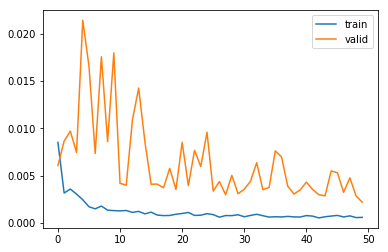

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [36]:
model.load_weights('saved_models/LSTM_stacked.hdf5')

In [37]:
preds = model.predict(X_test)

In [38]:
preds= y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test=y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))

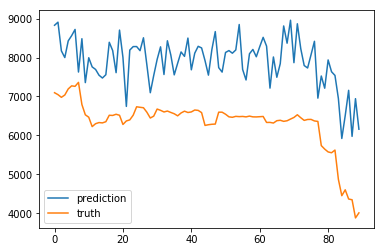

In [39]:
plt.plot(preds.ravel(), label='prediction')
plt.plot(y_test.ravel(), label='truth')
plt.legend()
plt.show()

In [40]:
np.sqrt(mean_squared_error(y_test,preds))

1647.7927784934432

# Multivariate LSTM Models

## Multiple Input Series 

In [7]:
def window_data(df, window_len):
    window_data = []
    for i in range(len(df) - window_len):
        tmp = df[i: (i + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [8]:
btc_data = pd.read_csv('BTC_DATA_fin.csv', index_col=0) #.set_index('Date').dropna(axis=1)
btc_data.index = pd.to_datetime(btc_data.index)

In [9]:
features_train = features[:len(features)-prediction_days]
features_test = features[len(features)-prediction_days:]

target_train = target[:len(features)-prediction_days]
target_test = target[len(features)-prediction_days:]

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))  
min_max_scaler = MinMaxScaler()

features_train = pd.DataFrame(min_max_scaler.fit_transform(features_train), 
                             columns=features_train.columns, 
                             index=features_train.index)
features_test = pd.DataFrame(min_max_scaler.transform(features_test), 
                             columns=features_test.columns, 
                             index=features_test.index)

In [11]:
y_scaler = MinMaxScaler()
target_train = y_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test = y_scaler.transform(target_test.values.reshape(-1, 1))

In [75]:
window_len=7
X_train = window_data(features_train, window_len=window_len)
X_test = window_data(features_test, window_len=window_len)
    

y_train = target_train[window_len:]
y_test = target_test[window_len:]

In [76]:
X_train.shape

(1939, 7, 29)

In [77]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear')) #'relu'

In [78]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [79]:
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM2_multi7', 
                               verbose=1, save_best_only=True)
epochs = 30 #100
batch_size=5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=1, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

Train on 1842 samples, validate on 97 samples
Epoch 1/30
1842/1842 [==============================] - 7s 4ms/step - loss: 0.0043 - val_loss: 6.5918e-04
Epoch 2/30
1842/1842 [==============================] - 6s 3ms/step - loss: 0.0015 - val_loss: 3.5185e-04
Epoch 3/30
1842/1842 [==============================] - 6s 3ms/step - loss: 0.0012 - val_loss: 7.7173e-04
Epoch 4/30
1842/1842 [==============================] - 6s 3ms/step - loss: 9.6806e-04 - val_loss: 8.3893e-04
Epoch 5/30
1842/1842 [==============================] - 6s 3ms/step - loss: 9.3347e-04 - val_loss: 0.0075
Epoch 6/30
1842/1842 [==============================] - 6s 3ms/step - loss: 8.1441e-04 - val_loss: 0.0035
Epoch 7/30
1842/1842 [==============================] - 6s 3ms/step - loss: 7.8487e-04 - val_loss: 0.0012
Epoch 8/30
1842/1842 [==============================] - 6s 3ms/step - loss: 6.4136e-04 - val_loss: 9.1692e-04
Epoch 9/30
1842/1842 [==============================] - 6s 3ms/step - loss: 6.6457e-04 - val_loss:

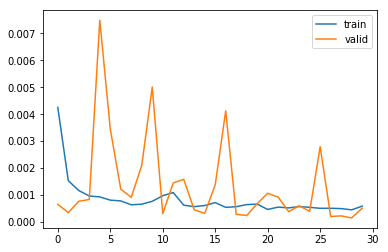

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [81]:
preds = model.predict(X_test)

In [82]:
preds= y_scaler.inverse_transform(preds)

In [83]:
y_test=y_scaler.inverse_transform(y_test)

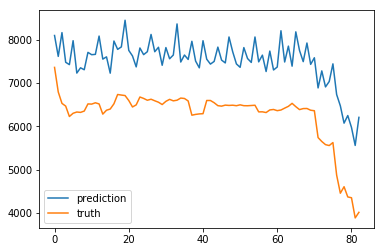

In [84]:
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [85]:
np.sqrt(mean_squared_error(y_test,preds))

1297.5057084002221

# Multiple Stacked LSTM

In [86]:
btc_data = pd.read_csv('BTC_DATA_fin.csv', index_col=0) #.set_index('Date').dropna(axis=1)
btc_data.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,Holiday,Weekend,wd_1,wd_2,...,N_tran,Diff,Block_Size,Mi_rev,Cost_tran,MA7,SO,Momentum_14,Momentum_7,Momentum_2
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,0.0,1488566728,0,1,0,0,...,40986.0,8.974296e+06,0.120677,572109.88793,13.958666,121.457143,0.543814,19.21,18.30,-4.79
2013-04-29,134.44,147.49,134.00,144.54,0.0,1603768865,0,0,1,0,...,50009.0,8.974296e+06,0.133635,645240.09120,12.902479,118.842857,0.781319,26.56,32.24,27.55
2013-04-30,144.00,146.93,134.05,139.00,0.0,1542813125,0,0,0,1,...,48795.0,1.007629e+07,0.176944,525692.91100,10.773500,114.237143,0.384317,27.50,27.50,33.79
2013-05-01,139.00,139.89,107.72,116.99,0.0,1298954594,1,0,0,0,...,50437.0,1.007629e+07,0.159960,442507.28800,8.773466,110.308571,0.288157,2.77,3.42,19.24
2013-05-02,116.38,125.60,92.28,105.21,0.0,1168517495,0,0,0,0,...,57278.0,1.007629e+07,0.181150,383775.10965,6.700218,109.820000,0.388055,-13.55,-7.46,-7.29


In [87]:
features_train = features[:len(features)-prediction_days]
features_test = features[len(features)-prediction_days:]

target_train = target[:len(features)-prediction_days]
target_test = target[len(features)-prediction_days:]

In [88]:
scaler = MinMaxScaler(feature_range=(0,1))  
min_max_scaler = MinMaxScaler()

features_train = pd.DataFrame(min_max_scaler.fit_transform(features_train), 
                             columns=features_train.columns, 
                             index=features_train.index)
features_test = pd.DataFrame(min_max_scaler.transform(features_test), 
                             columns=features_test.columns, 
                             index=features_test.index)

In [89]:
y_scaler = MinMaxScaler()
target_train = y_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test = y_scaler.transform(target_test.values.reshape(-1, 1))

In [90]:
window_len=7
X_train = window_data(features_train, window_len=window_len)
X_test = window_data(features_test, window_len=window_len)
    

y_train = target_train[window_len:]
y_test = target_test[window_len:]

In [91]:
model = Sequential()

model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.3)) #0.2
model.add(LSTM(128,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.5)) #0.2
model.add(Dense(units=1))
model.add(Activation('linear')) #'linear'

In [92]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [93]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_hz.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 30 #100
batch_size=10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

Train on 1745 samples, validate on 194 samples
Epoch 1/30
1745/1745 [==============================] - 7s 4ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 2/30
1745/1745 [==============================] - 5s 3ms/step - loss: 0.0018 - val_loss: 6.5120e-04
Epoch 3/30
1745/1745 [==============================] - 5s 3ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 4/30
1745/1745 [==============================] - 5s 3ms/step - loss: 0.0020 - val_loss: 6.6442e-04
Epoch 5/30
1745/1745 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 8.2518e-04
Epoch 6/30
1745/1745 [==============================] - 5s 3ms/step - loss: 8.3335e-04 - val_loss: 0.0023
Epoch 7/30
1745/1745 [==============================] - 5s 3ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/30
1745/1745 [==============================] - 5s 3ms/step - loss: 0.0010 - val_loss: 9.2929e-04
Epoch 9/30
1745/1745 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/30
174

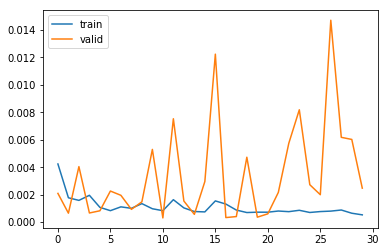

In [94]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [95]:
preds = model.predict(X_test)

In [96]:
preds= y_scaler.inverse_transform(preds)

In [97]:
y_test=y_scaler.inverse_transform(y_test)

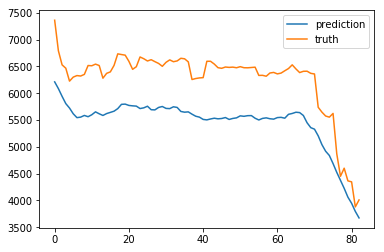

In [98]:
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [99]:
np.sqrt(mean_squared_error(y_test,preds))

825.76809341010778

# Different windows sizes

In [12]:
btc_data = pd.read_csv('BTC_DATA_fin.csv', index_col=0) #.set_index('Date').dropna(axis=1)

In [13]:
features_train = features[:len(features)-prediction_days]
features_test = features[len(features)-prediction_days:]

target_train = target[:len(features)-prediction_days]
target_test = target[len(features)-prediction_days:]

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))  
min_max_scaler = MinMaxScaler()

features_train = pd.DataFrame(min_max_scaler.fit_transform(features_train), 
                             columns=features_train.columns, 
                             index=features_train.index)
features_test = pd.DataFrame(min_max_scaler.transform(features_test), 
                             columns=features_test.columns, 
                             index=features_test.index)
y_scaler = MinMaxScaler()
target_train = y_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test = y_scaler.transform(target_test.values.reshape(-1, 1))

In [15]:
window_len=7
X_train = window_data(features_train, window_len=window_len)
X_test = window_data(features_test, window_len=window_len)
    

y_train = target_train[window_len:]
y_test = target_test[window_len:]

In [17]:
model = Sequential()

model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.3)) #0.2
model.add(LSTM(60,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.5)) #0.2
model.add(Dense(units=1))
model.add(Activation('linear')) #'linear'

In [18]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_stacked7.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 50 #100
batch_size=10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

Train on 1745 samples, validate on 194 samples
Epoch 1/50
1745/1745 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0143
Epoch 2/50
1745/1745 [==============================] - 3s 1ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/50
1745/1745 [==============================] - 2s 1ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 4/50
1745/1745 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 9.8505e-04
Epoch 5/50
1745/1745 [==============================] - 2s 1ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 6/50
1745/1745 [==============================] - 3s 1ms/step - loss: 0.0015 - val_loss: 0.0079
Epoch 7/50
1745/1745 [==============================] - 3s 2ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/50
1745/1745 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 9/50
1745/1745 [==============================] - 3s 1ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/50
1745/1745 [========

# WINDOWS SIZE = 1

In [222]:
model_name = 'saved_models/LSTM_stacked1.hdf5'
model.load_weights(model_name)

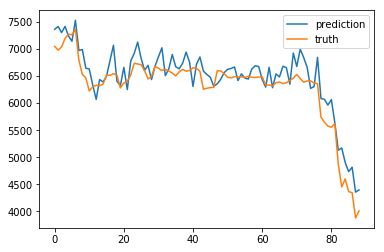

In [223]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [224]:
np.sqrt(mean_squared_error(y_test,preds))

271.0293846533724

# WINDOWS SIZE = 3

In [212]:
model_name = 'saved_models/LSTM_stacked3.hdf5'
model.load_weights(model_name)

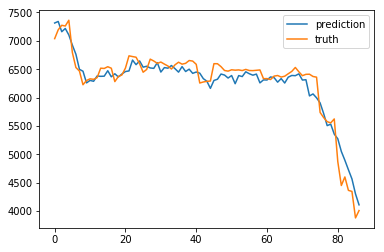

In [213]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [214]:
np.sqrt(mean_squared_error(y_test,preds))

175.51515122644432

# WINDOWS SIZE = 5

In [202]:
model_name = 'saved_models/LSTM_stacked5.hdf5'
model.load_weights(model_name)

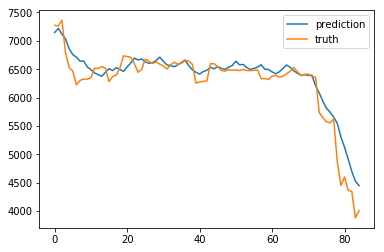

In [203]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [204]:
np.sqrt(mean_squared_error(y_test,preds))

228.50644241224546

# WINDOWS SIZE = 7

In [21]:
model_name = 'saved_models/LSTM_stacked7.hdf5'
model.load_weights(model_name)

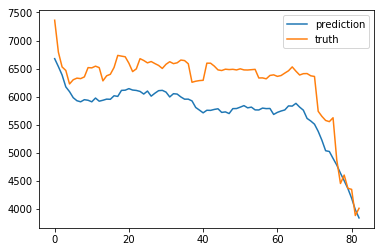

In [22]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [23]:
np.sqrt(mean_squared_error(y_test,preds))

565.53120029104662

# WINDOWS SIZE = 10

In [182]:
model_name = 'saved_models/LSTM_stacked10.hdf5'

In [183]:
model.load_weights(model_name)

In [179]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)

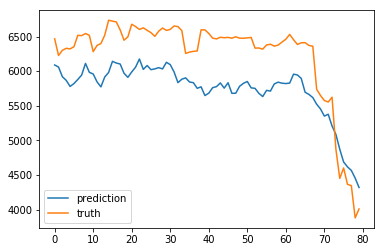

In [180]:
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [181]:
np.sqrt(mean_squared_error(y_test,preds))

573.3874849030318

'saved_models/LSTM_stacked7_128256.hdf5' error 203

# WINDOWS SIZE = 14

In [192]:
model_name = 'saved_models/LSTM_stacked10.hdf5'
model.load_weights(model_name)

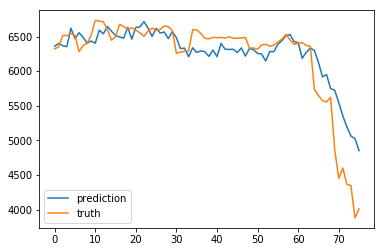

In [193]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [194]:
np.sqrt(mean_squared_error(y_test,preds))

324.24267261779994

# WINDOWS SIZE = 30

In [232]:
model_name = 'saved_models/LSTM_stacked30.hdf5'
model.load_weights(model_name)

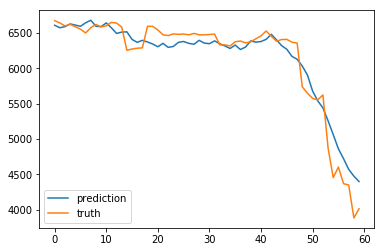

In [233]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [234]:
np.sqrt(mean_squared_error(y_test,preds))

189.69615091050716

# WINDOWS SIZE = 60

In [242]:
model_name = 'saved_models/LSTM_stacked60.hdf5'
model.load_weights(model_name)

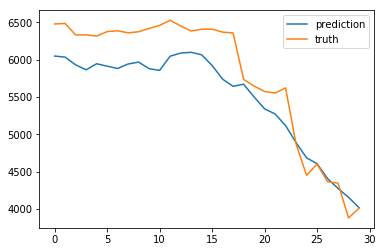

In [243]:
preds = model.predict(X_test)#.squeeze()
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [244]:
np.sqrt(mean_squared_error(y_test,preds))

392.85894218882976